In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *
from qick.rfboard import RFQickSoc216V1

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [2]:
# Load bitstream with custom overlay
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-08-23_216_tprocv2r20_rfb-spifix/qick_216_rfb.bit', clk_output=None)
soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-05_216_tprocv2r21_rfb/qick_216_rfb.bit', clk_output=None)

soccfg = soc

print(soccfg)

QICK running on ZCU216, software version 0.2.282

Firmware configuration (built Fri Sep  6 14:06:32 2024):

	Global clocks (MHz): tProcessor 384.000, RF reference 245.760

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (2.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (2.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 16384 samples (2.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (2.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_signal_gen_v6 - envelope memory 16384 samples (2.667 us)
		fs=6144.000 MHz, fabric=384.000 MH

In [5]:
class SimpleSweepProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", 
                               freq=cfg['freq'], 
                               gen_ch=gen_ch, 
                               outsel='input')

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
#                        mode='periodic'
                      )

        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

  0%|          | 0/10 [00:00<?, ?it/s]

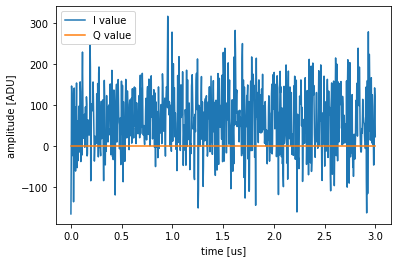

In [15]:
# do a sweep with 5 points and plot decimated
config = {'gen_ch': 2,
          'ro_ch': 1,
          'freq': 5000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 0.5,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

prog = SimpleSweepProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)



freq = config['freq']

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')



# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass')
# soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
# soc.rfb_set_gen_rf(config['gen_ch'], 5, 5)
soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)

#######
# ADC #
#######
# Set Filter.
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)


iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

  0%|          | 0/1 [00:00<?, ?it/s]

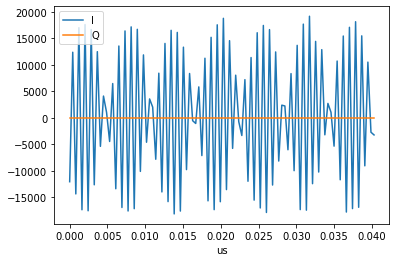

In [16]:
soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()[800:900]
t = prog.get_time_axis_mr(config['ro_ch'], iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0, 'MHz')

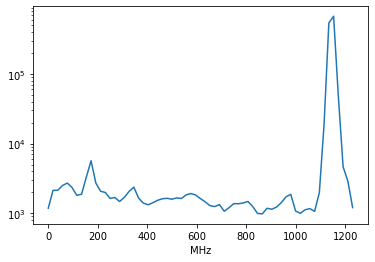

In [17]:
from scipy.signal import welch
from numpy.fft import fftshift

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')

# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)

iq_mr = soc.get_mr()[:,0]
fs_mr = soccfg['readouts'][config['ro_ch']]['fs']
# fft_freqs, psd = fftshift(welch(iq_mr, fs_mr, return_onesided=True, nperseg=128, detrend=False), axes=1)
fft_freqs, psd = welch(iq_mr, fs_mr, return_onesided=True, nperseg=128, detrend=False)
plt.semilogy(fft_freqs, psd)
plt.xlabel("MHz")

In [18]:
for chain in soc.dac_chains:
    chain.set_filter(fc=1.5, bw=1, ftype='bypass')
    chain.set_rf(5,5)

In [19]:
for chain in soc.adc_chains:
    chain.set_filter(fc=1.5, bw=1, ftype='bypass')
    chain.set_attn_db(5)

In [20]:
rfb_cfg = {'gen_ch': 3,
        'ro_ch': 0,
        'gen_att': (20,30),
        'ro_att': 30,
        }
soc.rfb_set_gen_rf(rfb_cfg['gen_ch'], *rfb_cfg['gen_att'])
soc.rfb_set_ro_rf(rfb_cfg['ro_ch'], rfb_cfg['ro_att'])

soc.rfb_set_ro_filter(rfb_cfg['ro_ch'], fc=1.0, ftype='bypass')
soc.rfb_set_gen_filter(rfb_cfg['gen_ch'], fc=1.0, ftype='bypass')


  0%|          | 0/1 [00:00<?, ?it/s]

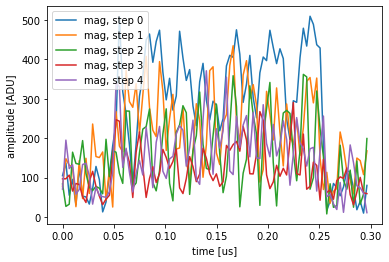

In [26]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 2,
          'ro_ch': 1,
          'freq': QickSweep1D("myloop", 4000, 7000),
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
soc.rfb_set_ro_rf(config['ro_ch'], 30)

prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

  0%|          | 0/5 [00:00<?, ?it/s]

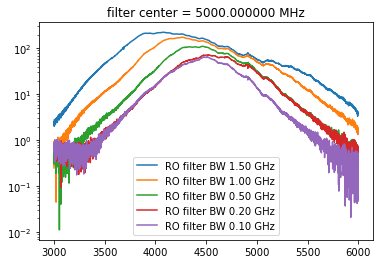

In [27]:
from tqdm.auto import tqdm
config['freq'] = QickSweep1D("myloop", 3000, 6000)
config['steps']=5001

freq = 5000

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     for chain in soc.adc_chains:
# #         chain.set_filter(fc=5.0, ftype='bandpass', bw=ro_bw)
#         chain.set_filter(fc=9.0, ftype='lowpass', bw=ro_bw)

#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=3.0, ftype='bandpass', bw=0.5)

    prog = FreqSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
    # plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
    # plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
    # plt.ylabel("Q [ADU]")
    # plt.xlabel("I [ADU]");

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", 
                               freq=cfg['freq'], 
                               gen_ch=gen_ch, 
                               outsel=cfg['ro_outsel'])

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)
        
        
        
config = {'gen_ch': 6,
          'ro_ch': 1,
          'freq': 3000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'ro_outsel': 'product',
          'pulse_len': 0.5,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

freq = config['freq']

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')



# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass')
# soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
# soc.rfb_set_gen_rf(config['gen_ch'], 5, 5)
soc.rfb_set_gen_rf(config['gen_ch'], 5, 20)

#######
# ADC #
#######
# Set Filter.
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 20)


iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=self.cfg['gen_nqz'])
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'], 
                                 style  = 'const', 
                                 freq   = freq,
                                 phase  = 0, 
                                 gain   = self.cfg['pulse_gain'], 
                                 length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0],
                     t               = self.us2cycles(self.cfg['pulse_start']),
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [5],
        "ro_length"   : 40,
        "ro_freq"     : 4000,
        "ro_offset"   : 0,
        
        "gen_ch"      : 12,        
        "gen_nqz"     : 2,
        "pulse_length": 20,
        "pulse_start" : 10,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 4000,
        
        "reps"        : 1,
        "period"      : 20
       }

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = config['pulse_freq']

# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=fc, ftype='bandpass')
soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 20)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'][0], 20)

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc)

# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


In [ ]:
from tqdm.auto import tqdm
for i in tqdm(range(1000)):
    soc.rfb_set_gen_rf(gen_ch=0, att1=15, att2=20)


### little note on the generator outputs
This firmware uses the "tmux" which multiplexes multiple generators onto each tProc output. Generally this works transparently, but be aware that if you try to play simultaneous pulses on generators that share a tmux channel, the pulses will get offset by a tProc clock cycle (or something like that).

In [ ]:
soccfg['gens']

In [ ]:
[(i,gen['tproc_ch']) for i,gen in enumerate(soccfg['gens'])]

In [ ]:
soc.ip_dict.keys()

### playing with LEDs (and ribbon I/O connector)
The LEDs are wired to the PMOD0 connector on the ZCU216, the ribbon is wired to PMOD1. In this firmware these are connected to an AxiGPIO which is controlled by software (vs. in most QICK firmware, where the PMODs are connected to the tProc). So these are for slow control.

The LEDs are very dim (trying to drive the LEDs directly with PMOD outputs?).

There is also some weirdness with the AxiGPIO we're using for this.

The ribbon connector works identically (`soc.pmod_bits_gpio` instead of `soc.pmod_led_gpio`), except that the pin mapping seems to be screwed up somewhere, such that even and odd pins are swapped: PMOD1_0=ribbon signal 1, PMOD 1_1=ribbon signal 0, etc. The ribbon pins should be input-capable, but I haven't checked.

In [ ]:
help(soc.pmod_led_gpio)

In [ ]:
# this works
while True:
    for ch in soc.pmod_led_gpio:
        ch.on()
    time.sleep(1)
    for ch in soc.pmod_led_gpio:
        ch.off()
    time.sleep(1)
    

In [ ]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].on()
            else:
                soc.pmod_led_gpio[j].off()
        time.sleep(0.2)

In [ ]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].write(1)
            else:
                soc.pmod_led_gpio[j].write(0)
        time.sleep(0.2)

In [ ]:
# this works
while True:
    for i in range(8):
        soc.pmod_led_gpio.channel1.write(val=1<<i, mask=0xFF)
        time.sleep(0.2)


In [ ]:
# this doesn't work, not sure why
while True:
    soc.pmod_led_gpio.channel1.write(0x0,0xFF)
    time.sleep(1)
    soc.pmod_led_gpio.channel1.write(0xFF,0xFF)
    time.sleep(1)
    

In [ ]:
help(soc.pmod_led_gpio.channel1.write)